# IMPORTS

In [1]:
import os
import re
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from collections import defaultdict
from scipy.stats import beta
from scipy.special import betaln
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

set_seed(42)

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'hsd-besra'
epochs = 10
batch_size = 64
sequence_length = 80

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/multi-label-hate-speech/oversampled-2.csv', encoding='latin-1')

alay_dict = pd.read_csv('/kaggle/input/multi-label-hate-speech/new_kamusalay.csv', encoding='latin-1', header=None)
alay_dict = alay_dict.rename(columns={0: 'original', 
                                      1: 'replacement'})

print("Shape: ", data.shape)
data.head()

Shape:  (14169, 13)


,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
1,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
2,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
4,deklarasi pilkada 2018 aman dan anti hoax warg...,0,0,0,0,0,0,0,0,0,0,0,0


In [7]:
data.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
1,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
2,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0
4,deklarasi pilkada 2018 aman dan anti hoax warg...,0,0,0,0,0,0,0,0,0,0,0,0


In [8]:
data.HS.value_counts()

HS
0    8084
1    6085
Name: count, dtype: int64

In [9]:
data.Abusive.value_counts()

Abusive
0    8084
1    6085
Name: count, dtype: int64

In [10]:
print("Toxic shape: ", data[(data['HS'] == 1) | (data['Abusive'] == 1)].shape)
print("Non-toxic shape: ", data[(data['HS'] == 0) & (data['Abusive'] == 0)].shape)

Toxic shape:  (8309, 13)
Non-toxic shape:  (5860, 13)


In [11]:
print("Shape: ", alay_dict.shape)
alay_dict.head(15)

Shape:  (15167, 2)


,original,replacement
0,anakjakartaasikasik,anak jakarta asyik asyik
1,pakcikdahtua,pak cik sudah tua
2,pakcikmudalagi,pak cik muda lagi
3,t3tapjokowi,tetap jokowi
4,3x,tiga kali
5,aamiin,amin
6,aamiinn,amin
7,aamin,amin
8,aammiin,amin
9,abis,habis


In [12]:
def lowercase(text):
    return text.lower()

def remove_unnecessary_char(text):
    text = re.sub('\n',' ',text) # Remove every '\n'
    text = re.sub('rt',' ',text) # Remove every retweet symbol
    text = re.sub('user',' ',text) # Remove every username
    text = re.sub('url', ' ', text) # Remove every URL
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
    text = re.sub(r'\b(?:x[a-fA-F0-9]{2}\s*)+\b', '', text) # Remove emoji bytecode
    text = re.sub('  +', ' ', text) # Remove extra spaces
    return text
    
def remove_nonaplhanumeric(text):
    text = re.sub('[^0-9a-zA-Z]+', ' ', text) 
    return text

alay_dict_map = dict(zip(alay_dict['original'], alay_dict['replacement']))
def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

print("remove_nonaplhanumeric: ", remove_nonaplhanumeric("Halooo,,,,, duniaa \x8f \xd2\1 !!"))
print("lowercase: ", lowercase("Halooo, duniaa!"))
print("remove_unnecessary_char: ", remove_unnecessary_char("Hehe\n\n RT USER USER apa kabs www.google.com\n  hehe URL xf8 x2a x89"))
print("normalize_alay: ", normalize_alay("aamiin adek abis"))

remove_nonaplhanumeric:  Halooo duniaa 
lowercase:  halooo, duniaa!
remove_unnecessary_char:  Hehe RT USER USER apa kabs hehe URL 
normalize_alay:  amin adik habis


In [13]:
def preprocess(text):
    text = lowercase(text)
    text = remove_nonaplhanumeric(text)
    text = remove_unnecessary_char(text)
    text = normalize_alay(text) 

    return text

In [14]:
data['Tweet'] = data['Tweet'].apply(preprocess)

# Define the labels columns for multi-label classification
label_columns = data.columns[1:]  # Assuming label columns start from the third column

train_data, val_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)

# Extract features and labels for training and validation
X_train = train_data['Tweet'].values
y_train = train_data[label_columns].values
X_val = val_data['Tweet'].values
y_val = val_data[label_columns].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(11335,) (11335, 12)
(2834,) (2834, 12)


# BUILD DATASET & DATALOADERS

In [15]:
class HateSpeechDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=64, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.use_float = use_float

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float if self.use_float else torch.long)
        return item

    def get_per_class_probs(self):
        """
        Calculate the spread of labels (0 and 1) for each class in the dataset.
        Returns:
            dict: A dictionary where keys are class indices and values are [count_0, count_1].
        """

        # Initialize a dictionary to store counts for each class
        label_counts = defaultdict(lambda: [0, 0])  # [count_0, count_1] for each class

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update counts for each class
            for class_idx, label in enumerate(labels):
                label_counts[class_idx][int(label)] += 1

        for key in label_counts.keys():
            total = sum(label_counts[key])
            label_counts[key] = [x / total for x in label_counts[key]]

        return label_counts

    def get_global_probs(self):
        """
        Calculate the global count of 0s and 1s across all classes in the dataset.
        Returns:
            dict: A dictionary with keys '0' and '1' representing their global counts.
        """
        global_counts = {'0': 0, '1': 0}

        for i in range(len(self)):
            # Get the labels for the i-th sample
            labels = self[i]['labels']

            # Update global counts
            for label in labels:
                global_counts[str(int(label))] += 1

        total = global_counts['0'] + global_counts['1']
        for key in global_counts.keys():
            global_counts[key] /= total

        return global_counts


# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p1')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [16]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=64, num_workers=4):
    train_dataset = HateSpeechDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = HateSpeechDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [17]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 250

In [18]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['HS', 'Abusive', 'HS_Individual', 'HS_Group', 'HS_Religion', 'HS_Race', 'HS_Physical', 'HS_Gender', 'HS_Other', 'HS_Weak', 'HS_Moderate', 'HS_Strong'],
        zero_division=0
    )   
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [19]:
def train_model(current_train_size, train_indices, metrics, trials, i):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p1',
            num_labels=len(label_columns),
            problem_type="multi_label_classification"
        )
        
    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()
    
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")

            nearest_cp = current_train_size
            if nearest_cp not in checkpoints:
                for cp in checkpoints:
                    if cp > current_train_size:
                        nearest_cp = cp
                        break
            percentage = math.ceil(nearest_cp / total_data * 100)
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials+1}-model-{i+1}-{percentage}',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    accelerator.print(f"Model {i+1} - Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
        
    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Training completed in {duration} s")
    
    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(best_result['accuracy'])
        metrics[1].append(best_result['f1_micro'])
        metrics[2].append(best_result['f1_macro'])

# PLOT RESULT

In [20]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [21]:
def beta_score(p, y, alpha=0.1, beta=3):
    """Calculates Beta score for a given probability p and label y."""
    
    if y == 1:
        return -betaln(alpha, beta + 1) + betaln(alpha + p, beta + 1 - p)
    elif y == 0:
        return -betaln(alpha + 1, beta) + betaln(alpha + 1 - p, beta + p)
    else:
        raise ValueError("Invalid label: y must be 0 or 1.")

def bayesian_update(prior, likelihood, evidence, alpha=0.1, beta_param=3):
    """ 
    Bayes' Theorem: P(y'|x') = P(x'|y') * P(y') / P(x')
    P(y'|x') or likelihood = model probs
    p(y') or prior = class probabilities
    p(x') or evidence = 1 / number of data
    """
    
    # Using the Beta score to simulate the posterior
    posterior = (likelihood * prior) / evidence
    
    # We calculate the posterior using the Beta distribution
    return posterior

def compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx):
    scores_before = []
    scores_after = []

    # Before data addition: calculate Beta score for predicted prob
    scores_before.append(beta_score(predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    scores_before.append(beta_score(1-predicted_prob, int(1 if predicted_prob >= 0.5 else 0)))
    
    # After data addition: use Bayesian update (posterior probability)
    for k in range(2):
        prior = predicted_prob
        likelihood = class_probs[class_idx][k]  # Likelihood is the true label (0 or 1)
        posterior = bayesian_update(prior, likelihood, 1)
        scores_after.append(beta_score(posterior, int(1 if posterior >= 0.5 else 0)))

    score_diff_0 = scores_after[0] - scores_before[0]
    score_diff_1 = scores_after[1] - scores_before[1]
    return label_probs['0'] * score_diff_0 + label_probs['1'] * score_diff_1

# Function to compute Expected Score Change (∆Q)
def besra_sampling(models, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device
    
    dataset = HateSpeechDataset(X_pool, np.zeros((len(X_pool), 12)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    current_train_size = len(train_indices)
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    labeled_dataset = HateSpeechDataset(current_X_train, current_y_train, tokenizer, max_length=sequence_length)
    label_probs = labeled_dataset.get_global_probs()
    class_probs = labeled_dataset.get_per_class_probs()

    for model in models:
        model.to(device)
        model.eval()
    start_time = time.time()
    score_changes = []

    for batch in dataloader:
        input_ids = batch['input_ids'].to(model.device)
        attention_mask = batch['attention_mask'].to(model.device)
        labels = batch['labels'].to(model.device)

        model_probs = []

        for model in models:
            with torch.no_grad():
                outputs = model(input_ids, attention_mask=attention_mask)
                logits = outputs.logits
                probs = torch.sigmoid(logits)  # Multi-label classification uses sigmoid
                model_probs.append(probs.unsqueeze(0))  # Add batch dimension for averaging
        
        # Stack all model predictions and compute the mean across models
        model_probs = torch.cat(model_probs, dim=0)  # Concatenate predictions across models
        probs = model_probs.mean(dim=0)  # Take the mean along the model axis

        # Calculate Beta scores before and after data addition
        for i in range(len(probs)):
            score_diff = []
            for class_idx in range(probs.shape[1]):
                predicted_prob = probs[i, class_idx].item()
                score_diff.append(compute_expected_score_change(predicted_prob, class_probs, label_probs, class_idx))
            
            score_changes.append(np.mean(score_diff))
    
    accelerator.wait_for_everyone()    
    if accelerator.is_local_main_process:
        score_changes = np.array(score_changes)
        score_changes = score_changes.reshape(-1, 1)

        target_samples = math.ceil(0.1 * len(X_pool))
        collected_indices = set()
        thresholds = []
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break

        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size

        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                'HS': [y_train[i][0] for i in temp],
                'Abusive': [y_train[i][1] for i in temp],
                'HS_Individual': [y_train[i][2] for i in temp],
                'HS_Group': [y_train[i][3] for i in temp],
                'HS_Religion': [y_train[i][4] for i in temp],
                'HS_Race': [y_train[i][5] for i in temp],
                'HS_Physical': [y_train[i][6] for i in temp],
                'HS_Gender': [y_train[i][7] for i in temp],
                'HS_Other': [y_train[i][8] for i in temp],
                'HS_Weak': [y_train[i][9] for i in temp],
                'HS_Moderate': [y_train[i][10] for i in temp],
                'HS_Strong': [y_train[i][11] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)

        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(score_changes)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(score_changes[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 90)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances >= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    'HS': [y_train[i][0] for i in temp],
                    'Abusive': [y_train[i][1] for i in temp],
                    'HS_Individual': [y_train[i][2] for i in temp],
                    'HS_Group': [y_train[i][3] for i in temp],
                    'HS_Religion': [y_train[i][4] for i in temp],
                    'HS_Race': [y_train[i][5] for i in temp],
                    'HS_Physical': [y_train[i][6] for i in temp],
                    'HS_Gender': [y_train[i][7] for i in temp],
                    'HS_Other': [y_train[i][8] for i in temp],
                    'HS_Weak': [y_train[i][9] for i in temp],
                    'HS_Moderate': [y_train[i][10] for i in temp],
                    'HS_Strong': [y_train[i][11] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            # print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

        threshold_data = pd.DataFrame({
            'Threshold': thresholds
        })
        threshold_data.to_csv(f"results/{filename}-thresholds-{trials+1}-{current_train_size}.csv", index=False)

# MAIN LOOP

In [22]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()
    
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size

    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        model_accuracies = manager.list()
        model_f1_micros = manager.list()
        model_f1_macros = manager.list()
        
        # Train the model
        for j in range(3):
            set_seed(seed[j])
            args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
            notebook_launcher(train_model, args, num_processes=2)

        data_used.append(current_train_size)
        accuracies.append(np.mean(model_accuracies))
        f1_micros.append(np.mean(model_f1_micros))
        f1_macros.append(np.mean(model_f1_macros))
        print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")

        nearest_cp = current_train_size
        if nearest_cp not in checkpoints:
            for cp in checkpoints:
                if cp > current_train_size:
                    nearest_cp = cp
                    break
        percentage = math.ceil(nearest_cp / total_data * 100)
        
        models = []
        for j in range(3):
            model = BertForSequenceClassification.from_pretrained(f'{filename}-{i+1}-model-{j+1}-{percentage}')
            models.append(model)
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (models, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(besra_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    model_accuracies = manager.list()
    model_f1_micros = manager.list()
    model_f1_macros = manager.list()
    
    for j in range(3):
        set_seed(seed[j])
        args = (current_train_size, train_indices, (model_accuracies, model_f1_micros, model_f1_macros), i, j)
        notebook_launcher(train_model, args, num_processes=2)
        
    data_used.append(current_train_size)
    accuracies.append(np.mean(model_accuracies))
    f1_micros.append(np.mean(model_f1_micros))
    f1_macros.append(np.mean(model_f1_macros))
    print(f"Averaged - Iteration {current_train_size}: Accuracy: {round(np.mean(model_accuracies), 4)}, F1 Micro: {round(np.mean(model_f1_micros), 4)}, F1 Macro: {round(np.mean(model_f1_macros), 4)}")
        
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

# RUN THE LOOP

TRIAL 1
Random seed: [50, 67, 42]
Launching training on 2 GPUs.


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6193, Accuracy: 0.8179, F1 Micro: 0.1675, F1 Macro: 0.042
Epoch 2/10, Train Loss: 0.4754, Accuracy: 0.8236, F1 Micro: 0.0569, F1 Macro: 0.0213
Epoch 3/10, Train Loss: 0.4294, Accuracy: 0.8278, F1 Micro: 0.0973, F1 Macro: 0.0345
Epoch 4/10, Train Loss: 0.4087, Accuracy: 0.8308, F1 Micro: 0.1389, F1 Macro: 0.0464
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3988, Accuracy: 0.8447, F1 Micro: 0.311, F1 Macro: 0.1026
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3953, Accuracy: 0.8496, F1 Micro: 0.3724, F1 Macro: 0.1355
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3624, Accuracy: 0.8544, F1 Micro: 0.4227, F1 Macro: 0.1763
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3528, Accuracy: 0.8635, F1 Micro: 0.4792, F1 Macro: 0.2524
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3212, Accuracy: 0.872, F1 Micro: 0.5442, F1 Macro: 0.3354
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6334, Accuracy: 0.816, F1 Micro: 0.2121, F1 Macro: 0.0538
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4873, Accuracy: 0.8345, F1 Micro: 0.3019, F1 Macro: 0.0931
Epoch 3/10, Train Loss: 0.4333, Accuracy: 0.8367, F1 Micro: 0.2255, F1 Macro: 0.0747
Epoch 4/10, Train Loss: 0.4097, Accuracy: 0.8386, F1 Micro: 0.235, F1 Macro: 0.0813
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3991, Accuracy: 0.845, F1 Micro: 0.3172, F1 Macro: 0.1022
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.3952, Accuracy: 0.8469, F1 Micro: 0.3746, F1 Macro: 0.1168
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3622, Accuracy: 0.8547, F1 Micro: 0.4134, F1 Macro: 0.1499
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.3503, Accuracy: 0.8612, F1 Micro: 0.448, F1 Macro: 0.2086
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3256, Accuracy: 0.8692, F1 Micro: 0.5328, F1 Macro: 0.3081
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6503, Accuracy: 0.8023, F1 Micro: 0.3936, F1 Macro: 0.1097
Epoch 2/10, Train Loss: 0.4856, Accuracy: 0.8299, F1 Micro: 0.1514, F1 Macro: 0.0483
Epoch 3/10, Train Loss: 0.4273, Accuracy: 0.8314, F1 Micro: 0.1528, F1 Macro: 0.0539
Epoch 4/10, Train Loss: 0.4026, Accuracy: 0.8316, F1 Micro: 0.156, F1 Macro: 0.0507
Epoch 5/10, Train Loss: 0.3918, Accuracy: 0.8477, F1 Micro: 0.3471, F1 Macro: 0.1212
Epoch 6/10, Train Loss: 0.3907, Accuracy: 0.8489, F1 Micro: 0.3857, F1 Macro: 0.1423
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.3598, Accuracy: 0.8528, F1 Micro: 0.4163, F1 Macro: 0.1829
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.348, Accuracy: 0.8582, F1 Micro: 0.4491, F1 Macro: 0.2294
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.3243, Accuracy: 0.8669, F1 Micro: 0.5173, F1 Macro: 0.2945
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.3038, Accuracy: 0.8721, F1 Micro: 0.5301, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5327, Accuracy: 0.8288, F1 Micro: 0.1122, F1 Macro: 0.0433
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4301, Accuracy: 0.8474, F1 Micro: 0.3441, F1 Macro: 0.1084
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3896, Accuracy: 0.8573, F1 Micro: 0.4306, F1 Macro: 0.1917
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.352, Accuracy: 0.8691, F1 Micro: 0.4904, F1 Macro: 0.2888
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3032, Accuracy: 0.8861, F1 Micro: 0.6229, F1 Macro: 0.4702
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2716, Accuracy: 0.8923, F1 Micro: 0.6393, F1 Macro: 0.5321
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2369, Accuracy: 0.8987, F1 Micro: 0.6844, F1 Macro: 0.5909
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2093, Accuracy: 0.9032, F1 Micro: 0.7034, F1 Macro: 0.6217
Epoch 9/10, Train Loss: 0.1831, Accuracy: 0.9052, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5462, Accuracy: 0.8386, F1 Micro: 0.3369, F1 Macro: 0.1022
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4313, Accuracy: 0.845, F1 Micro: 0.3684, F1 Macro: 0.1105
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3925, Accuracy: 0.8556, F1 Micro: 0.426, F1 Macro: 0.1599
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3586, Accuracy: 0.8693, F1 Micro: 0.5093, F1 Macro: 0.2792
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3067, Accuracy: 0.8779, F1 Micro: 0.5459, F1 Macro: 0.3766
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2754, Accuracy: 0.8925, F1 Micro: 0.6676, F1 Macro: 0.5573
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2442, Accuracy: 0.8987, F1 Micro: 0.676, F1 Macro: 0.5719
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2126, Accuracy: 0.9015, F1 Micro: 0.6814, F1 Macro: 0.5896
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5495, Accuracy: 0.8278, F1 Micro: 0.1141, F1 Macro: 0.039
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.4272, Accuracy: 0.8464, F1 Micro: 0.341, F1 Macro: 0.1077
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3865, Accuracy: 0.8538, F1 Micro: 0.4104, F1 Macro: 0.1699
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.3573, Accuracy: 0.8692, F1 Micro: 0.5078, F1 Macro: 0.294
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.3062, Accuracy: 0.877, F1 Micro: 0.5472, F1 Macro: 0.3985
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.277, Accuracy: 0.8907, F1 Micro: 0.6625, F1 Macro: 0.5482
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.2457, Accuracy: 0.8963, F1 Micro: 0.6665, F1 Macro: 0.5594
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2171, Accuracy: 0.8985, F1 Micro: 0.6713, F1 Macro: 0.575
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.189

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5005, Accuracy: 0.8365, F1 Micro: 0.2135, F1 Macro: 0.0705
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3986, Accuracy: 0.8567, F1 Micro: 0.4185, F1 Macro: 0.167
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3364, Accuracy: 0.8781, F1 Micro: 0.5725, F1 Macro: 0.3734
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2759, Accuracy: 0.8919, F1 Micro: 0.637, F1 Macro: 0.5207
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.232, Accuracy: 0.9032, F1 Micro: 0.6889, F1 Macro: 0.6089
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2051, Accuracy: 0.907, F1 Micro: 0.7015, F1 Macro: 0.616
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.177, Accuracy: 0.9139, F1 Micro: 0.7462, F1 Macro: 0.6842
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1525, Accuracy: 0.9163, F1 Micro: 0.7502, F1 Macro: 0.6929
Epoch 9/10, Train Loss: 0.1302, Accuracy: 0.9179, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5077, Accuracy: 0.8331, F1 Micro: 0.1651, F1 Macro: 0.0569
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3997, Accuracy: 0.8532, F1 Micro: 0.3837, F1 Macro: 0.1317
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3441, Accuracy: 0.8773, F1 Micro: 0.5858, F1 Macro: 0.3691
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2817, Accuracy: 0.8919, F1 Micro: 0.6275, F1 Macro: 0.4993
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.239, Accuracy: 0.9031, F1 Micro: 0.6909, F1 Macro: 0.601
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2137, Accuracy: 0.9104, F1 Micro: 0.724, F1 Macro: 0.6405
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1815, Accuracy: 0.9123, F1 Micro: 0.7388, F1 Macro: 0.6726
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1579, Accuracy: 0.9166, F1 Micro: 0.7492, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5098, Accuracy: 0.8348, F1 Micro: 0.1996, F1 Macro: 0.0688
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3937, Accuracy: 0.8535, F1 Micro: 0.4151, F1 Macro: 0.1583
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.339, Accuracy: 0.878, F1 Micro: 0.5792, F1 Macro: 0.3882
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2819, Accuracy: 0.8895, F1 Micro: 0.6181, F1 Macro: 0.4966
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2378, Accuracy: 0.9011, F1 Micro: 0.6905, F1 Macro: 0.6034
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2133, Accuracy: 0.9057, F1 Micro: 0.6983, F1 Macro: 0.6097
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1856, Accuracy: 0.913, F1 Micro: 0.7407, F1 Macro: 0.6651
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1621, Accuracy: 0.9154, F1 Micro: 0.7483, F1 Macro: 0.6751
Epoch 9/10, Train Loss: 0.14, Accuracy: 0.9177, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4801, Accuracy: 0.8393, F1 Micro: 0.2358, F1 Macro: 0.0802
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3686, Accuracy: 0.876, F1 Micro: 0.5801, F1 Macro: 0.3609
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2983, Accuracy: 0.8945, F1 Micro: 0.671, F1 Macro: 0.5722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2503, Accuracy: 0.9059, F1 Micro: 0.715, F1 Macro: 0.6318
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.206, Accuracy: 0.9111, F1 Micro: 0.7449, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1767, Accuracy: 0.9143, F1 Micro: 0.7489, F1 Macro: 0.6905
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1524, Accuracy: 0.9189, F1 Micro: 0.7579, F1 Macro: 0.701
Epoch 8/10, Train Loss: 0.1355, Accuracy: 0.9211, F1 Micro: 0.7558, F1 Macro: 0.7064
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1159, Accuracy: 0.9228, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.488, Accuracy: 0.8451, F1 Micro: 0.3142, F1 Macro: 0.1018
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3741, Accuracy: 0.8696, F1 Micro: 0.5574, F1 Macro: 0.3222
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3028, Accuracy: 0.8933, F1 Micro: 0.6572, F1 Macro: 0.5421
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2508, Accuracy: 0.9059, F1 Micro: 0.7019, F1 Macro: 0.6132
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2111, Accuracy: 0.9127, F1 Micro: 0.7464, F1 Macro: 0.6759
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1765, Accuracy: 0.917, F1 Micro: 0.7577, F1 Macro: 0.7005
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1547, Accuracy: 0.9191, F1 Micro: 0.7588, F1 Macro: 0.7047
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1378, Accuracy: 0.9213, F1 Micro: 0.764, F1 Macro: 0.7164
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4881, Accuracy: 0.8368, F1 Micro: 0.2213, F1 Macro: 0.0708
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3709, Accuracy: 0.8693, F1 Micro: 0.5328, F1 Macro: 0.2858
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.3021, Accuracy: 0.8921, F1 Micro: 0.656, F1 Macro: 0.5468
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2519, Accuracy: 0.9023, F1 Micro: 0.6882, F1 Macro: 0.5924
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.2097, Accuracy: 0.9107, F1 Micro: 0.7404, F1 Macro: 0.6621
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1803, Accuracy: 0.9162, F1 Micro: 0.7459, F1 Macro: 0.6756
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1541, Accuracy: 0.9177, F1 Micro: 0.762, F1 Macro: 0.7024
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1413, Accuracy: 0.9215, F1 Micro: 0.7681, F1 Macro: 0.7189
Epoch 9/10, Train Loss: 0.1166, Accuracy: 0.922, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4635, Accuracy: 0.8478, F1 Micro: 0.36, F1 Macro: 0.1135
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3526, Accuracy: 0.8803, F1 Micro: 0.5804, F1 Macro: 0.4041
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2707, Accuracy: 0.902, F1 Micro: 0.7039, F1 Macro: 0.6207
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2251, Accuracy: 0.9106, F1 Micro: 0.7241, F1 Macro: 0.6501
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1907, Accuracy: 0.9156, F1 Micro: 0.7429, F1 Macro: 0.6774
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1589, Accuracy: 0.9225, F1 Micro: 0.7705, F1 Macro: 0.7099
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1367, Accuracy: 0.924, F1 Micro: 0.7721, F1 Macro: 0.7241
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1191, Accuracy: 0.923, F1 Micro: 0.7831, F1 Macro: 0.742
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.101

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4711, Accuracy: 0.8482, F1 Micro: 0.3698, F1 Macro: 0.1126
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3579, Accuracy: 0.8764, F1 Micro: 0.5423, F1 Macro: 0.3394
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.275, Accuracy: 0.9014, F1 Micro: 0.6874, F1 Macro: 0.586
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2324, Accuracy: 0.9121, F1 Micro: 0.7276, F1 Macro: 0.6472
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1953, Accuracy: 0.9169, F1 Micro: 0.7528, F1 Macro: 0.683
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1652, Accuracy: 0.9211, F1 Micro: 0.7691, F1 Macro: 0.705
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1411, Accuracy: 0.9224, F1 Micro: 0.7802, F1 Macro: 0.7346
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1234, Accuracy: 0.9236, F1 Micro: 0.7818, F1 Macro: 0.7359
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4682, Accuracy: 0.8468, F1 Micro: 0.3556, F1 Macro: 0.1144
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3563, Accuracy: 0.8784, F1 Micro: 0.559, F1 Macro: 0.3662
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2763, Accuracy: 0.8992, F1 Micro: 0.6753, F1 Macro: 0.5685
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2325, Accuracy: 0.9092, F1 Micro: 0.7173, F1 Macro: 0.6396
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1955, Accuracy: 0.9148, F1 Micro: 0.7386, F1 Macro: 0.6651
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1644, Accuracy: 0.9219, F1 Micro: 0.7684, F1 Macro: 0.7055
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1414, Accuracy: 0.9209, F1 Micro: 0.7751, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1261, Accuracy: 0.9243, F1 Micro: 0.7808, F1 Macro: 0.7341
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4634, Accuracy: 0.8533, F1 Micro: 0.432, F1 Macro: 0.1616
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3379, Accuracy: 0.887, F1 Micro: 0.6171, F1 Macro: 0.4467
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2676, Accuracy: 0.9049, F1 Micro: 0.7182, F1 Macro: 0.6526
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2195, Accuracy: 0.9153, F1 Micro: 0.7372, F1 Macro: 0.6713
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1766, Accuracy: 0.9208, F1 Micro: 0.7748, F1 Macro: 0.7194
Epoch 6/10, Train Loss: 0.1553, Accuracy: 0.9176, F1 Micro: 0.7617, F1 Macro: 0.7144
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1273, Accuracy: 0.9272, F1 Micro: 0.7867, F1 Macro: 0.7432
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1052, Accuracy: 0.9275, F1 Micro: 0.7919, F1 Macro: 0.7553
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0941, Accuracy: 0.9285, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4686, Accuracy: 0.8488, F1 Micro: 0.3903, F1 Macro: 0.1185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3421, Accuracy: 0.8863, F1 Micro: 0.6051, F1 Macro: 0.417
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2724, Accuracy: 0.9049, F1 Micro: 0.7186, F1 Macro: 0.6493
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2242, Accuracy: 0.9159, F1 Micro: 0.7412, F1 Macro: 0.679
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.182, Accuracy: 0.9225, F1 Micro: 0.7705, F1 Macro: 0.7122
Epoch 6/10, Train Loss: 0.1586, Accuracy: 0.9195, F1 Micro: 0.7632, F1 Macro: 0.7152
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1322, Accuracy: 0.9293, F1 Micro: 0.7906, F1 Macro: 0.748
Epoch 8/10, Train Loss: 0.1118, Accuracy: 0.9261, F1 Micro: 0.7854, F1 Macro: 0.742
Epoch 9/10, Train Loss: 0.0998, Accuracy: 0.9241, F1 Micro: 0.7865, F1 Macro: 0.7547
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4668, Accuracy: 0.8505, F1 Micro: 0.4212, F1 Macro: 0.1636
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3411, Accuracy: 0.8838, F1 Micro: 0.5912, F1 Macro: 0.4346
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2747, Accuracy: 0.9025, F1 Micro: 0.714, F1 Macro: 0.6389
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2261, Accuracy: 0.9156, F1 Micro: 0.7415, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1826, Accuracy: 0.9213, F1 Micro: 0.7647, F1 Macro: 0.6935
Epoch 6/10, Train Loss: 0.1592, Accuracy: 0.9179, F1 Micro: 0.7602, F1 Macro: 0.707
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1351, Accuracy: 0.929, F1 Micro: 0.789, F1 Macro: 0.7441
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1101, Accuracy: 0.9283, F1 Micro: 0.7924, F1 Macro: 0.7502
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0968, Accuracy: 0.9303, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4522, Accuracy: 0.854, F1 Micro: 0.4295, F1 Macro: 0.174
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3241, Accuracy: 0.8945, F1 Micro: 0.664, F1 Macro: 0.5534
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2531, Accuracy: 0.9115, F1 Micro: 0.7231, F1 Macro: 0.6365
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2103, Accuracy: 0.9196, F1 Micro: 0.7518, F1 Macro: 0.692
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1726, Accuracy: 0.9262, F1 Micro: 0.7802, F1 Macro: 0.7325
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9277, F1 Micro: 0.7896, F1 Macro: 0.7491
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1231, Accuracy: 0.9301, F1 Micro: 0.7953, F1 Macro: 0.7615
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1056, Accuracy: 0.9304, F1 Micro: 0.801, F1 Macro: 0.7711
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.08

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4575, Accuracy: 0.8541, F1 Micro: 0.4244, F1 Macro: 0.1473
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3273, Accuracy: 0.8939, F1 Micro: 0.6587, F1 Macro: 0.5469
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2577, Accuracy: 0.9112, F1 Micro: 0.7186, F1 Macro: 0.6333
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2128, Accuracy: 0.9197, F1 Micro: 0.7469, F1 Macro: 0.6784
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.178, Accuracy: 0.9259, F1 Micro: 0.7813, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1476, Accuracy: 0.9292, F1 Micro: 0.7897, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1294, Accuracy: 0.9282, F1 Micro: 0.7962, F1 Macro: 0.7591
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1105, Accuracy: 0.9305, F1 Micro: 0.8044, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4536, Accuracy: 0.8522, F1 Micro: 0.4031, F1 Macro: 0.1618
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3267, Accuracy: 0.8918, F1 Micro: 0.6544, F1 Macro: 0.5436
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2588, Accuracy: 0.9082, F1 Micro: 0.7098, F1 Macro: 0.6212
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2161, Accuracy: 0.9184, F1 Micro: 0.7511, F1 Macro: 0.6818
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1801, Accuracy: 0.9252, F1 Micro: 0.7777, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1475, Accuracy: 0.9291, F1 Micro: 0.7877, F1 Macro: 0.7419
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1253, Accuracy: 0.9302, F1 Micro: 0.7978, F1 Macro: 0.758
Epoch 8/10, Train Loss: 0.1087, Accuracy: 0.9317, F1 Micro: 0.793, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0909, Accuracy: 0.9324, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4477, Accuracy: 0.862, F1 Micro: 0.456, F1 Macro: 0.2065
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3102, Accuracy: 0.8965, F1 Micro: 0.6701, F1 Macro: 0.567
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2424, Accuracy: 0.913, F1 Micro: 0.7427, F1 Macro: 0.6773
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2003, Accuracy: 0.9221, F1 Micro: 0.7615, F1 Macro: 0.706
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1689, Accuracy: 0.9269, F1 Micro: 0.7742, F1 Macro: 0.728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1418, Accuracy: 0.9302, F1 Micro: 0.7964, F1 Macro: 0.7583
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1156, Accuracy: 0.9302, F1 Micro: 0.8024, F1 Macro: 0.7717
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1004, Accuracy: 0.9337, F1 Micro: 0.8119, F1 Macro: 0.7851
Epoch 9/10, Train Loss: 0.0862, Accuracy: 0.9361, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4523, Accuracy: 0.8608, F1 Micro: 0.4535, F1 Macro: 0.1886
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3159, Accuracy: 0.8968, F1 Micro: 0.6694, F1 Macro: 0.5568
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2464, Accuracy: 0.9129, F1 Micro: 0.7249, F1 Macro: 0.6419
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2058, Accuracy: 0.9228, F1 Micro: 0.7661, F1 Macro: 0.711
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1753, Accuracy: 0.9273, F1 Micro: 0.7798, F1 Macro: 0.731
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1432, Accuracy: 0.9287, F1 Micro: 0.7912, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1196, Accuracy: 0.9321, F1 Micro: 0.8024, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1034, Accuracy: 0.9323, F1 Micro: 0.8058, F1 Macro: 0.7752
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4491, Accuracy: 0.8594, F1 Micro: 0.4595, F1 Macro: 0.2069
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3151, Accuracy: 0.8968, F1 Micro: 0.6728, F1 Macro: 0.5636
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.25, Accuracy: 0.9111, F1 Micro: 0.727, F1 Macro: 0.6519
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.207, Accuracy: 0.9216, F1 Micro: 0.765, F1 Macro: 0.7043
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1763, Accuracy: 0.9268, F1 Micro: 0.7743, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1472, Accuracy: 0.9283, F1 Micro: 0.7886, F1 Macro: 0.7446
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1216, Accuracy: 0.9309, F1 Micro: 0.7996, F1 Macro: 0.7642
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1022, Accuracy: 0.9342, F1 Micro: 0.808, F1 Macro: 0.7762
Epoch 9/10, Train Loss: 0.0864, Accuracy: 0.9331, F1 Micro: 0.80

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4365, Accuracy: 0.8685, F1 Micro: 0.4893, F1 Macro: 0.2443
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3018, Accuracy: 0.9, F1 Micro: 0.6825, F1 Macro: 0.6011
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2375, Accuracy: 0.9161, F1 Micro: 0.7433, F1 Macro: 0.6723
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1915, Accuracy: 0.9227, F1 Micro: 0.7729, F1 Macro: 0.7215
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1625, Accuracy: 0.9256, F1 Micro: 0.7914, F1 Macro: 0.7476
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1361, Accuracy: 0.9316, F1 Micro: 0.8032, F1 Macro: 0.7691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1124, Accuracy: 0.9335, F1 Micro: 0.8039, F1 Macro: 0.7721
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0939, Accuracy: 0.9335, F1 Micro: 0.814, F1 Macro: 0.787
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4418, Accuracy: 0.8656, F1 Micro: 0.4846, F1 Macro: 0.2307
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3085, Accuracy: 0.8999, F1 Micro: 0.6842, F1 Macro: 0.5982
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.243, Accuracy: 0.9165, F1 Micro: 0.7529, F1 Macro: 0.6789
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1987, Accuracy: 0.9224, F1 Micro: 0.7704, F1 Macro: 0.7128
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1689, Accuracy: 0.9248, F1 Micro: 0.7909, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1392, Accuracy: 0.9312, F1 Micro: 0.7972, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1155, Accuracy: 0.9344, F1 Micro: 0.8074, F1 Macro: 0.7757
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.934, F1 Micro: 0.8108, F1 Macro: 0.7799
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4406, Accuracy: 0.8636, F1 Micro: 0.4642, F1 Macro: 0.2414
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3079, Accuracy: 0.8983, F1 Micro: 0.6862, F1 Macro: 0.605
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.243, Accuracy: 0.914, F1 Micro: 0.732, F1 Macro: 0.6543
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1987, Accuracy: 0.9214, F1 Micro: 0.764, F1 Macro: 0.7045
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.167, Accuracy: 0.9284, F1 Micro: 0.789, F1 Macro: 0.7365
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1402, Accuracy: 0.9308, F1 Micro: 0.7972, F1 Macro: 0.7588
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1175, Accuracy: 0.9324, F1 Micro: 0.7975, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.097, Accuracy: 0.9335, F1 Micro: 0.8115, F1 Macro: 0.7823
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0826,

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4356, Accuracy: 0.8655, F1 Micro: 0.4745, F1 Macro: 0.2171
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3002, Accuracy: 0.9043, F1 Micro: 0.6984, F1 Macro: 0.6224
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2319, Accuracy: 0.9177, F1 Micro: 0.742, F1 Macro: 0.6663
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1923, Accuracy: 0.9274, F1 Micro: 0.7779, F1 Macro: 0.727
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.929, F1 Micro: 0.7911, F1 Macro: 0.7509
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1304, Accuracy: 0.9342, F1 Micro: 0.8077, F1 Macro: 0.775
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1105, Accuracy: 0.9361, F1 Micro: 0.8086, F1 Macro: 0.777
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.094, Accuracy: 0.9372, F1 Micro: 0.8141, F1 Macro: 0.7894
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.078

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4402, Accuracy: 0.8632, F1 Micro: 0.4525, F1 Macro: 0.2035
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3026, Accuracy: 0.9019, F1 Micro: 0.69, F1 Macro: 0.6134
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2351, Accuracy: 0.9159, F1 Micro: 0.7321, F1 Macro: 0.6478
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1966, Accuracy: 0.9262, F1 Micro: 0.7748, F1 Macro: 0.7177
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1586, Accuracy: 0.9287, F1 Micro: 0.7938, F1 Macro: 0.7521
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1343, Accuracy: 0.9344, F1 Micro: 0.805, F1 Macro: 0.7691
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.11, Accuracy: 0.938, F1 Micro: 0.8171, F1 Macro: 0.788
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0962, Accuracy: 0.9387, F1 Micro: 0.8218, F1 Macro: 0.7968
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0792

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.437, Accuracy: 0.8638, F1 Micro: 0.4584, F1 Macro: 0.2185
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3023, Accuracy: 0.9006, F1 Micro: 0.6779, F1 Macro: 0.5906
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2363, Accuracy: 0.9141, F1 Micro: 0.727, F1 Macro: 0.6426
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.199, Accuracy: 0.9255, F1 Micro: 0.7782, F1 Macro: 0.7191
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1627, Accuracy: 0.9292, F1 Micro: 0.7914, F1 Macro: 0.7477
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1355, Accuracy: 0.9324, F1 Micro: 0.7953, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.116, Accuracy: 0.9341, F1 Micro: 0.7995, F1 Macro: 0.7671
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0944, Accuracy: 0.9363, F1 Micro: 0.814, F1 Macro: 0.7913
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.07

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4269, Accuracy: 0.8726, F1 Micro: 0.5243, F1 Macro: 0.3043
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2888, Accuracy: 0.9055, F1 Micro: 0.7285, F1 Macro: 0.6542
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2273, Accuracy: 0.92, F1 Micro: 0.7542, F1 Macro: 0.6944
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.182, Accuracy: 0.9303, F1 Micro: 0.7973, F1 Macro: 0.7554
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1533, Accuracy: 0.928, F1 Micro: 0.8016, F1 Macro: 0.7674
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1264, Accuracy: 0.9358, F1 Micro: 0.8137, F1 Macro: 0.7823
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1039, Accuracy: 0.938, F1 Micro: 0.8204, F1 Macro: 0.7957
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.939, F1 Micro: 0.8215, F1 Macro: 0.7956
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.074

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4321, Accuracy: 0.8696, F1 Micro: 0.5024, F1 Macro: 0.2776
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2919, Accuracy: 0.9079, F1 Micro: 0.7141, F1 Macro: 0.6302
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2286, Accuracy: 0.92, F1 Micro: 0.767, F1 Macro: 0.7103
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1874, Accuracy: 0.9298, F1 Micro: 0.7952, F1 Macro: 0.7517
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1564, Accuracy: 0.9296, F1 Micro: 0.8039, F1 Macro: 0.7689
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9356, F1 Micro: 0.8157, F1 Macro: 0.7815
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1069, Accuracy: 0.938, F1 Micro: 0.8233, F1 Macro: 0.7978
Epoch 8/10, Train Loss: 0.0907, Accuracy: 0.9396, F1 Micro: 0.8224, F1 Macro: 0.7957
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0791, Accuracy: 0.9418, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4303, Accuracy: 0.8691, F1 Micro: 0.492, F1 Macro: 0.2724
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2933, Accuracy: 0.9056, F1 Micro: 0.709, F1 Macro: 0.6141
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2314, Accuracy: 0.9203, F1 Micro: 0.7538, F1 Macro: 0.6816
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1885, Accuracy: 0.9294, F1 Micro: 0.7975, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1563, Accuracy: 0.9325, F1 Micro: 0.8061, F1 Macro: 0.7692
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1283, Accuracy: 0.9355, F1 Micro: 0.8149, F1 Macro: 0.7806
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.937, F1 Micro: 0.8207, F1 Macro: 0.7933
Epoch 8/10, Train Loss: 0.0886, Accuracy: 0.9383, F1 Micro: 0.8206, F1 Macro: 0.7971
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0771, Accuracy: 0.941, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4277, Accuracy: 0.8712, F1 Micro: 0.4991, F1 Macro: 0.2915
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.285, Accuracy: 0.907, F1 Micro: 0.6951, F1 Macro: 0.6021
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2228, Accuracy: 0.9242, F1 Micro: 0.7791, F1 Macro: 0.7308
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1768, Accuracy: 0.9334, F1 Micro: 0.806, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1474, Accuracy: 0.9357, F1 Micro: 0.8143, F1 Macro: 0.7807
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.124, Accuracy: 0.9393, F1 Micro: 0.8221, F1 Macro: 0.7954
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1011, Accuracy: 0.9411, F1 Micro: 0.8299, F1 Macro: 0.8051
Epoch 8/10, Train Loss: 0.0844, Accuracy: 0.94, F1 Micro: 0.8289, F1 Macro: 0.8098
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0714, Accuracy: 0.9426, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4337, Accuracy: 0.8694, F1 Micro: 0.4865, F1 Macro: 0.2609
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2893, Accuracy: 0.9057, F1 Micro: 0.6897, F1 Macro: 0.5871
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2264, Accuracy: 0.9237, F1 Micro: 0.7674, F1 Macro: 0.7136
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1831, Accuracy: 0.932, F1 Micro: 0.8001, F1 Macro: 0.7563
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1522, Accuracy: 0.9342, F1 Micro: 0.8087, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.9376, F1 Micro: 0.8179, F1 Macro: 0.793
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1044, Accuracy: 0.9397, F1 Micro: 0.8303, F1 Macro: 0.8059
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0874, Accuracy: 0.9427, F1 Micro: 0.8366, F1 Macro: 0.8169
Epoch 9/10, Train Loss: 0.0762, Accuracy: 0.9417, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4307, Accuracy: 0.8708, F1 Micro: 0.4983, F1 Macro: 0.2685
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2899, Accuracy: 0.9048, F1 Micro: 0.6882, F1 Macro: 0.5904
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2287, Accuracy: 0.923, F1 Micro: 0.7743, F1 Macro: 0.7161
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1838, Accuracy: 0.9308, F1 Micro: 0.8029, F1 Macro: 0.7633
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1537, Accuracy: 0.9352, F1 Micro: 0.8043, F1 Macro: 0.768
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1269, Accuracy: 0.9372, F1 Micro: 0.8181, F1 Macro: 0.7902
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1043, Accuracy: 0.9412, F1 Micro: 0.8266, F1 Macro: 0.8024
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.085, Accuracy: 0.9409, F1 Micro: 0.8309, F1 Macro: 0.8107
Epoch 9/10, Train Loss: 0.0746, Accuracy: 0.9414, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4225, Accuracy: 0.8775, F1 Micro: 0.5573, F1 Macro: 0.3607
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.286, Accuracy: 0.912, F1 Micro: 0.722, F1 Macro: 0.6357
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2153, Accuracy: 0.9261, F1 Micro: 0.7745, F1 Macro: 0.7181
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1725, Accuracy: 0.9343, F1 Micro: 0.8112, F1 Macro: 0.7774
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9382, F1 Micro: 0.818, F1 Macro: 0.7886
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1144, Accuracy: 0.937, F1 Micro: 0.8239, F1 Macro: 0.7977
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0975, Accuracy: 0.9372, F1 Micro: 0.8271, F1 Macro: 0.806
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0836, Accuracy: 0.9434, F1 Micro: 0.8384, F1 Macro: 0.8169
Epoch 9/10, Train Loss: 0.0707, Accuracy: 0.9433, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4279, Accuracy: 0.8742, F1 Micro: 0.5339, F1 Macro: 0.3109
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2917, Accuracy: 0.9082, F1 Micro: 0.6982, F1 Macro: 0.6008
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2215, Accuracy: 0.9269, F1 Micro: 0.7792, F1 Macro: 0.7252
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.179, Accuracy: 0.9334, F1 Micro: 0.8049, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1468, Accuracy: 0.9361, F1 Micro: 0.8102, F1 Macro: 0.7728
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9409, F1 Micro: 0.8301, F1 Macro: 0.8029
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0995, Accuracy: 0.9394, F1 Micro: 0.8325, F1 Macro: 0.8114
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.087, Accuracy: 0.9418, F1 Micro: 0.8362, F1 Macro: 0.8138
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.423, Accuracy: 0.8781, F1 Micro: 0.5743, F1 Macro: 0.375
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.29, Accuracy: 0.9069, F1 Micro: 0.6947, F1 Macro: 0.5974
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2226, Accuracy: 0.9238, F1 Micro: 0.7659, F1 Macro: 0.6993
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1792, Accuracy: 0.9321, F1 Micro: 0.8094, F1 Macro: 0.7778
Epoch 5/10, Train Loss: 0.1496, Accuracy: 0.9354, F1 Micro: 0.809, F1 Macro: 0.772
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1192, Accuracy: 0.9379, F1 Micro: 0.8222, F1 Macro: 0.7931
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0999, Accuracy: 0.9354, F1 Micro: 0.8226, F1 Macro: 0.8012
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9435, F1 Micro: 0.8365, F1 Macro: 0.8173
Epoch 9/10, Train Loss: 0.0719, Accuracy: 0.9428, F1 Micro: 0.8361, F1 Macro: 0.8189
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4169, Accuracy: 0.8794, F1 Micro: 0.5677, F1 Macro: 0.3833
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2753, Accuracy: 0.9106, F1 Micro: 0.7019, F1 Macro: 0.6217
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2146, Accuracy: 0.9283, F1 Micro: 0.7829, F1 Macro: 0.7405
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1696, Accuracy: 0.9332, F1 Micro: 0.8088, F1 Macro: 0.7768
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1429, Accuracy: 0.9392, F1 Micro: 0.8211, F1 Macro: 0.7982
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1189, Accuracy: 0.9406, F1 Micro: 0.8297, F1 Macro: 0.8067
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9386, F1 Micro: 0.8259, F1 Macro: 0.8025
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0811, Accuracy: 0.944, F1 Micro: 0.8408, F1 Macro: 0.8222
Epoch 9/10, Train Loss: 0.0696, Accuracy: 0.9442, F1 Micro: 0.8399, F1 Macro: 0.8224
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4226, Accuracy: 0.8777, F1 Micro: 0.5588, F1 Macro: 0.3573
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2805, Accuracy: 0.9092, F1 Micro: 0.7004, F1 Macro: 0.6215
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2211, Accuracy: 0.9272, F1 Micro: 0.7772, F1 Macro: 0.7233
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1773, Accuracy: 0.9317, F1 Micro: 0.8025, F1 Macro: 0.7654
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1491, Accuracy: 0.9391, F1 Micro: 0.823, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1268, Accuracy: 0.941, F1 Micro: 0.8274, F1 Macro: 0.8039
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1016, Accuracy: 0.9408, F1 Micro: 0.8333, F1 Macro: 0.8115
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0855, Accuracy: 0.9447, F1 Micro: 0.8385, F1 Macro: 0.8212
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4221, Accuracy: 0.8762, F1 Micro: 0.5555, F1 Macro: 0.368
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2828, Accuracy: 0.9057, F1 Micro: 0.6811, F1 Macro: 0.5879
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2216, Accuracy: 0.9279, F1 Micro: 0.7814, F1 Macro: 0.722
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1762, Accuracy: 0.9326, F1 Micro: 0.8057, F1 Macro: 0.7684
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1465, Accuracy: 0.9387, F1 Micro: 0.8188, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1233, Accuracy: 0.9379, F1 Micro: 0.8257, F1 Macro: 0.8006
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9401, F1 Micro: 0.8315, F1 Macro: 0.8087
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.084, Accuracy: 0.9397, F1 Micro: 0.8339, F1 Macro: 0.8151
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4174, Accuracy: 0.8806, F1 Micro: 0.588, F1 Macro: 0.3869
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2727, Accuracy: 0.9146, F1 Micro: 0.7524, F1 Macro: 0.6905
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2127, Accuracy: 0.9297, F1 Micro: 0.7909, F1 Macro: 0.7479
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1651, Accuracy: 0.9363, F1 Micro: 0.8149, F1 Macro: 0.7856
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1384, Accuracy: 0.9391, F1 Micro: 0.826, F1 Macro: 0.7983
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9432, F1 Micro: 0.8346, F1 Macro: 0.8135
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9416, F1 Micro: 0.8354, F1 Macro: 0.8127
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9464, F1 Micro: 0.8454, F1 Macro: 0.8283
Epoch 9/10, Train Loss: 0.0678, Accuracy: 0.9442, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4224, Accuracy: 0.8781, F1 Micro: 0.5576, F1 Macro: 0.336
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.279, Accuracy: 0.9127, F1 Micro: 0.7478, F1 Macro: 0.6795
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2155, Accuracy: 0.9303, F1 Micro: 0.7914, F1 Macro: 0.7433
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.169, Accuracy: 0.9371, F1 Micro: 0.8149, F1 Macro: 0.7798
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1439, Accuracy: 0.9401, F1 Micro: 0.8298, F1 Macro: 0.8016
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1221, Accuracy: 0.9423, F1 Micro: 0.838, F1 Macro: 0.8147
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0976, Accuracy: 0.9445, F1 Micro: 0.842, F1 Macro: 0.8197
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0807, Accuracy: 0.9462, F1 Micro: 0.8472, F1 Macro: 0.8296
Epoch 9/10, Train Loss: 0.069, Accuracy: 0.9452, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4226, Accuracy: 0.8787, F1 Micro: 0.5611, F1 Macro: 0.3444
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2804, Accuracy: 0.9113, F1 Micro: 0.7389, F1 Macro: 0.6632
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2187, Accuracy: 0.9286, F1 Micro: 0.7867, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.171, Accuracy: 0.9359, F1 Micro: 0.8088, F1 Macro: 0.7698
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1426, Accuracy: 0.9398, F1 Micro: 0.8272, F1 Macro: 0.7967
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1191, Accuracy: 0.9438, F1 Micro: 0.8379, F1 Macro: 0.8147
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.097, Accuracy: 0.9446, F1 Micro: 0.842, F1 Macro: 0.8213
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0778, Accuracy: 0.9453, F1 Micro: 0.8442, F1 Macro: 0.8259
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4221, Accuracy: 0.8799, F1 Micro: 0.5562, F1 Macro: 0.3756
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.277, Accuracy: 0.9182, F1 Micro: 0.7461, F1 Macro: 0.6725
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2072, Accuracy: 0.9279, F1 Micro: 0.7759, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1709, Accuracy: 0.9372, F1 Micro: 0.8113, F1 Macro: 0.7729
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1359, Accuracy: 0.9382, F1 Micro: 0.827, F1 Macro: 0.8016
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1142, Accuracy: 0.9411, F1 Micro: 0.8358, F1 Macro: 0.8144
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0891, Accuracy: 0.9435, F1 Micro: 0.841, F1 Macro: 0.8217
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0776, Accuracy: 0.9456, F1 Micro: 0.8472, F1 Macro: 0.8307
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4269, Accuracy: 0.8792, F1 Micro: 0.5575, F1 Macro: 0.3483
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2827, Accuracy: 0.9169, F1 Micro: 0.742, F1 Macro: 0.6635
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2123, Accuracy: 0.9284, F1 Micro: 0.7772, F1 Macro: 0.7363
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1756, Accuracy: 0.9378, F1 Micro: 0.8171, F1 Macro: 0.7816
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1386, Accuracy: 0.94, F1 Micro: 0.8265, F1 Macro: 0.7996
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1174, Accuracy: 0.9427, F1 Micro: 0.8387, F1 Macro: 0.8135
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9403, F1 Micro: 0.8358, F1 Macro: 0.8149
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0822, Accuracy: 0.9467, F1 Micro: 0.8477, F1 Macro: 0.8303
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0684, Accuracy: 0.9481, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4246, Accuracy: 0.8741, F1 Micro: 0.5103, F1 Macro: 0.3203
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2855, Accuracy: 0.9144, F1 Micro: 0.7362, F1 Macro: 0.6573
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2157, Accuracy: 0.9271, F1 Micro: 0.7714, F1 Macro: 0.7266
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1766, Accuracy: 0.9365, F1 Micro: 0.8144, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1398, Accuracy: 0.9402, F1 Micro: 0.8278, F1 Macro: 0.7997
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1166, Accuracy: 0.9423, F1 Micro: 0.8375, F1 Macro: 0.8159
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9436, F1 Micro: 0.8418, F1 Macro: 0.8235
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0795, Accuracy: 0.9452, F1 Micro: 0.846, F1 Macro: 0.8286
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4141, Accuracy: 0.8867, F1 Micro: 0.6134, F1 Macro: 0.4361
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2713, Accuracy: 0.9197, F1 Micro: 0.7568, F1 Macro: 0.6909
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2105, Accuracy: 0.9319, F1 Micro: 0.7992, F1 Macro: 0.761
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1665, Accuracy: 0.9375, F1 Micro: 0.8198, F1 Macro: 0.786
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1345, Accuracy: 0.9412, F1 Micro: 0.8314, F1 Macro: 0.8035
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1148, Accuracy: 0.9425, F1 Micro: 0.8388, F1 Macro: 0.8168
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0938, Accuracy: 0.946, F1 Micro: 0.8457, F1 Macro: 0.8258
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0786, Accuracy: 0.9471, F1 Micro: 0.8504, F1 Macro: 0.8334
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4203, Accuracy: 0.8849, F1 Micro: 0.6184, F1 Macro: 0.4301
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.278, Accuracy: 0.9179, F1 Micro: 0.7489, F1 Macro: 0.6783
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2151, Accuracy: 0.9317, F1 Micro: 0.7959, F1 Macro: 0.7528
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1704, Accuracy: 0.9357, F1 Micro: 0.8153, F1 Macro: 0.7819
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.139, Accuracy: 0.9402, F1 Micro: 0.8296, F1 Macro: 0.8004
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1169, Accuracy: 0.9442, F1 Micro: 0.8404, F1 Macro: 0.8174
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0946, Accuracy: 0.947, F1 Micro: 0.8462, F1 Macro: 0.8286
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0812, Accuracy: 0.9474, F1 Micro: 0.8479, F1 Macro: 0.8301
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4198, Accuracy: 0.8834, F1 Micro: 0.6064, F1 Macro: 0.432
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2782, Accuracy: 0.916, F1 Micro: 0.7418, F1 Macro: 0.6672
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2176, Accuracy: 0.9308, F1 Micro: 0.7941, F1 Macro: 0.7505
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1723, Accuracy: 0.9364, F1 Micro: 0.8158, F1 Macro: 0.7805
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1391, Accuracy: 0.9401, F1 Micro: 0.8309, F1 Macro: 0.8038
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1154, Accuracy: 0.9442, F1 Micro: 0.8399, F1 Macro: 0.8194
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0965, Accuracy: 0.945, F1 Micro: 0.8426, F1 Macro: 0.8232
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.079, Accuracy: 0.946, F1 Micro: 0.8449, F1 Macro: 0.8285
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.06

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4093, Accuracy: 0.8889, F1 Micro: 0.6351, F1 Macro: 0.4997
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2639, Accuracy: 0.9222, F1 Micro: 0.772, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2031, Accuracy: 0.9318, F1 Micro: 0.8013, F1 Macro: 0.7627
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9377, F1 Micro: 0.8245, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1321, Accuracy: 0.9429, F1 Micro: 0.835, F1 Macro: 0.8135
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.11, Accuracy: 0.9451, F1 Micro: 0.8427, F1 Macro: 0.8208
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0898, Accuracy: 0.9452, F1 Micro: 0.8468, F1 Macro: 0.829
Epoch 8/10, Train Loss: 0.0763, Accuracy: 0.9455, F1 Micro: 0.8441, F1 Macro: 0.8261
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0659, Accuracy: 0.9475, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4154, Accuracy: 0.8871, F1 Micro: 0.6378, F1 Macro: 0.4906
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2694, Accuracy: 0.9206, F1 Micro: 0.7583, F1 Macro: 0.6935
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2074, Accuracy: 0.9323, F1 Micro: 0.8028, F1 Macro: 0.7644
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1686, Accuracy: 0.9359, F1 Micro: 0.8191, F1 Macro: 0.7847
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9426, F1 Micro: 0.8329, F1 Macro: 0.8069
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1139, Accuracy: 0.9456, F1 Micro: 0.8428, F1 Macro: 0.8176
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0933, Accuracy: 0.9472, F1 Micro: 0.8491, F1 Macro: 0.8299
Epoch 8/10, Train Loss: 0.0804, Accuracy: 0.9464, F1 Micro: 0.8474, F1 Macro: 0.8292
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0664, Accuracy: 0.9483, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4143, Accuracy: 0.8856, F1 Micro: 0.6313, F1 Macro: 0.4836
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2706, Accuracy: 0.9194, F1 Micro: 0.7515, F1 Macro: 0.6873
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2091, Accuracy: 0.9302, F1 Micro: 0.7986, F1 Macro: 0.7536
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1694, Accuracy: 0.9381, F1 Micro: 0.8242, F1 Macro: 0.7944
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1331, Accuracy: 0.9417, F1 Micro: 0.8345, F1 Macro: 0.8087
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1113, Accuracy: 0.9454, F1 Micro: 0.8436, F1 Macro: 0.8181
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.091, Accuracy: 0.9467, F1 Micro: 0.8483, F1 Macro: 0.8278
Epoch 8/10, Train Loss: 0.0797, Accuracy: 0.9451, F1 Micro: 0.8452, F1 Macro: 0.8282
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0663, Accuracy: 0.9467, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4107, Accuracy: 0.891, F1 Micro: 0.6528, F1 Macro: 0.4934
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.9234, F1 Micro: 0.7685, F1 Macro: 0.7245
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1999, Accuracy: 0.9337, F1 Micro: 0.8097, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1579, Accuracy: 0.9382, F1 Micro: 0.8287, F1 Macro: 0.8014
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1313, Accuracy: 0.944, F1 Micro: 0.8397, F1 Macro: 0.8134
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1052, Accuracy: 0.9423, F1 Micro: 0.8399, F1 Macro: 0.8213
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0882, Accuracy: 0.9477, F1 Micro: 0.8524, F1 Macro: 0.8359
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0742, Accuracy: 0.9485, F1 Micro: 0.8542, F1 Macro: 0.838
Epoch 9/10, Train Loss: 0.0622, Accuracy: 0.9472, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4156, Accuracy: 0.8878, F1 Micro: 0.6528, F1 Macro: 0.4975
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2663, Accuracy: 0.9202, F1 Micro: 0.757, F1 Macro: 0.6996
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.206, Accuracy: 0.9329, F1 Micro: 0.8012, F1 Macro: 0.7631
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1652, Accuracy: 0.9404, F1 Micro: 0.828, F1 Macro: 0.7954
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1399, Accuracy: 0.9445, F1 Micro: 0.841, F1 Macro: 0.8159
Epoch 6/10, Train Loss: 0.1096, Accuracy: 0.9407, F1 Micro: 0.8371, F1 Macro: 0.817
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0906, Accuracy: 0.9444, F1 Micro: 0.8456, F1 Macro: 0.8282
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0767, Accuracy: 0.9495, F1 Micro: 0.857, F1 Macro: 0.8399
Epoch 9/10, Train Loss: 0.066, Accuracy: 0.9486, F1 Micro: 0.8564, F1 Macro: 0.8395
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4154, Accuracy: 0.8875, F1 Micro: 0.6305, F1 Macro: 0.4494
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2683, Accuracy: 0.9179, F1 Micro: 0.7553, F1 Macro: 0.6976
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2057, Accuracy: 0.9314, F1 Micro: 0.8028, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1644, Accuracy: 0.9385, F1 Micro: 0.8266, F1 Macro: 0.7947
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1361, Accuracy: 0.9441, F1 Micro: 0.8409, F1 Macro: 0.8163
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1088, Accuracy: 0.9458, F1 Micro: 0.8441, F1 Macro: 0.8257
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0907, Accuracy: 0.9467, F1 Micro: 0.8491, F1 Macro: 0.8325
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0769, Accuracy: 0.9504, F1 Micro: 0.8572, F1 Macro: 0.8439
Epoch 9/10, Train Loss: 0.0651, Accuracy: 0.9489, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4077, Accuracy: 0.8935, F1 Micro: 0.6567, F1 Macro: 0.529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2609, Accuracy: 0.9226, F1 Micro: 0.7564, F1 Macro: 0.7037
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1963, Accuracy: 0.9346, F1 Micro: 0.8056, F1 Macro: 0.7727
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1615, Accuracy: 0.9405, F1 Micro: 0.8236, F1 Macro: 0.7957
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1308, Accuracy: 0.9427, F1 Micro: 0.8319, F1 Macro: 0.8095
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1086, Accuracy: 0.9415, F1 Micro: 0.8399, F1 Macro: 0.8204
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0893, Accuracy: 0.9482, F1 Micro: 0.8532, F1 Macro: 0.836
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.948, F1 Micro: 0.8532, F1 Macro: 0.8342
Epoch 9/10, Train Loss: 0.0633, Accuracy: 0.9462, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4143, Accuracy: 0.889, F1 Micro: 0.6538, F1 Macro: 0.4968
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2683, Accuracy: 0.9186, F1 Micro: 0.7423, F1 Macro: 0.6742
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2009, Accuracy: 0.9335, F1 Micro: 0.7988, F1 Macro: 0.7649
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1667, Accuracy: 0.9398, F1 Micro: 0.8197, F1 Macro: 0.7867
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1374, Accuracy: 0.945, F1 Micro: 0.8384, F1 Macro: 0.8139
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1107, Accuracy: 0.944, F1 Micro: 0.8434, F1 Macro: 0.8218
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9483, F1 Micro: 0.8544, F1 Macro: 0.8358
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0764, Accuracy: 0.9497, F1 Micro: 0.8549, F1 Macro: 0.8365
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.413, Accuracy: 0.8901, F1 Micro: 0.6517, F1 Macro: 0.5113
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2687, Accuracy: 0.9192, F1 Micro: 0.7456, F1 Macro: 0.6791
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2024, Accuracy: 0.9333, F1 Micro: 0.8024, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.164, Accuracy: 0.9408, F1 Micro: 0.8228, F1 Macro: 0.7933
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1332, Accuracy: 0.9446, F1 Micro: 0.842, F1 Macro: 0.8209
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.108, Accuracy: 0.9435, F1 Micro: 0.8443, F1 Macro: 0.8247
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0904, Accuracy: 0.9488, F1 Micro: 0.8554, F1 Macro: 0.8373
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.946, F1 Micro: 0.8514, F1 Macro: 0.8338
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.064, Accuracy: 0.9502, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4037, Accuracy: 0.8921, F1 Micro: 0.6494, F1 Macro: 0.5172
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2569, Accuracy: 0.9226, F1 Micro: 0.7836, F1 Macro: 0.7447
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1976, Accuracy: 0.9342, F1 Micro: 0.8075, F1 Macro: 0.7744
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1574, Accuracy: 0.9412, F1 Micro: 0.8306, F1 Macro: 0.8039
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1263, Accuracy: 0.9436, F1 Micro: 0.8393, F1 Macro: 0.813
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1038, Accuracy: 0.9434, F1 Micro: 0.8417, F1 Macro: 0.8228
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.086, Accuracy: 0.9484, F1 Micro: 0.8536, F1 Macro: 0.8352
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0723, Accuracy: 0.95, F1 Micro: 0.8582, F1 Macro: 0.8425
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4106, Accuracy: 0.8925, F1 Micro: 0.6523, F1 Macro: 0.5102
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2618, Accuracy: 0.9234, F1 Micro: 0.7808, F1 Macro: 0.7348
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2015, Accuracy: 0.9335, F1 Micro: 0.8089, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1635, Accuracy: 0.941, F1 Micro: 0.8275, F1 Macro: 0.7963
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1316, Accuracy: 0.9421, F1 Micro: 0.8339, F1 Macro: 0.8109
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1093, Accuracy: 0.9465, F1 Micro: 0.8502, F1 Macro: 0.8321
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0896, Accuracy: 0.9461, F1 Micro: 0.8513, F1 Macro: 0.8356
Epoch 8/10, Train Loss: 0.0753, Accuracy: 0.9453, F1 Micro: 0.8501, F1 Macro: 0.8355
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0629, Accuracy: 0.9511, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4079, Accuracy: 0.8916, F1 Micro: 0.66, F1 Macro: 0.5332
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.263, Accuracy: 0.9222, F1 Micro: 0.773, F1 Macro: 0.7117
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2035, Accuracy: 0.9344, F1 Micro: 0.8107, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1618, Accuracy: 0.9418, F1 Micro: 0.833, F1 Macro: 0.8058
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9444, F1 Micro: 0.8421, F1 Macro: 0.8148
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1063, Accuracy: 0.9439, F1 Micro: 0.8439, F1 Macro: 0.8255
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0887, Accuracy: 0.9467, F1 Micro: 0.8515, F1 Macro: 0.8345
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0751, Accuracy: 0.9479, F1 Micro: 0.8547, F1 Macro: 0.841
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.062

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.402, Accuracy: 0.8939, F1 Micro: 0.6546, F1 Macro: 0.5341
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2507, Accuracy: 0.9254, F1 Micro: 0.7712, F1 Macro: 0.7214
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1949, Accuracy: 0.9336, F1 Micro: 0.8096, F1 Macro: 0.7822
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1553, Accuracy: 0.943, F1 Micro: 0.836, F1 Macro: 0.812
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.939, F1 Micro: 0.834, F1 Macro: 0.8132
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9441, F1 Micro: 0.846, F1 Macro: 0.8267
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0833, Accuracy: 0.9462, F1 Micro: 0.8506, F1 Macro: 0.8329
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0697, Accuracy: 0.946, F1 Micro: 0.8525, F1 Macro: 0.8373
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0616, Accuracy: 0.9506, F1 Micro: 0.859

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4068, Accuracy: 0.8905, F1 Micro: 0.6289, F1 Macro: 0.5023
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2576, Accuracy: 0.923, F1 Micro: 0.7596, F1 Macro: 0.7013
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2006, Accuracy: 0.9341, F1 Micro: 0.8022, F1 Macro: 0.7701
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1605, Accuracy: 0.9418, F1 Micro: 0.8316, F1 Macro: 0.8034
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1307, Accuracy: 0.9415, F1 Micro: 0.8386, F1 Macro: 0.817
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1092, Accuracy: 0.9477, F1 Micro: 0.8492, F1 Macro: 0.8304
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0868, Accuracy: 0.9477, F1 Micro: 0.8556, F1 Macro: 0.8378
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0727, Accuracy: 0.9518, F1 Micro: 0.8629, F1 Macro: 0.8467
Epoch 9/10, Train Loss: 0.0614, Accuracy: 0.9482, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4045, Accuracy: 0.8918, F1 Micro: 0.6499, F1 Macro: 0.53
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2568, Accuracy: 0.9207, F1 Micro: 0.7496, F1 Macro: 0.6928
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1985, Accuracy: 0.9337, F1 Micro: 0.8044, F1 Macro: 0.7705
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9428, F1 Micro: 0.8335, F1 Macro: 0.8052
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1267, Accuracy: 0.941, F1 Micro: 0.8376, F1 Macro: 0.8149
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.107, Accuracy: 0.9488, F1 Micro: 0.8527, F1 Macro: 0.8333
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0849, Accuracy: 0.9502, F1 Micro: 0.857, F1 Macro: 0.8377
Epoch 8/10, Train Loss: 0.0713, Accuracy: 0.9459, F1 Micro: 0.8514, F1 Macro: 0.8373
Epoch 9/10, Train Loss: 0.062, Accuracy: 0.9457, F1 Micro: 0.8499, F1 Macro: 0.8368
Higher F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3981, Accuracy: 0.8949, F1 Micro: 0.6464, F1 Macro: 0.5061
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2479, Accuracy: 0.9271, F1 Micro: 0.7755, F1 Macro: 0.7266
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1864, Accuracy: 0.9342, F1 Micro: 0.7981, F1 Macro: 0.7598
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1527, Accuracy: 0.9417, F1 Micro: 0.8297, F1 Macro: 0.8018
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.119, Accuracy: 0.9445, F1 Micro: 0.844, F1 Macro: 0.8206
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9433, F1 Micro: 0.8444, F1 Macro: 0.8277
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.081, Accuracy: 0.9453, F1 Micro: 0.8497, F1 Macro: 0.8335
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0659, Accuracy: 0.9506, F1 Micro: 0.8604, F1 Macro: 0.8463
Epoch 9/10, Train Loss: 0.0561, Accuracy: 0.9466, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4054, Accuracy: 0.8878, F1 Micro: 0.6036, F1 Macro: 0.4411
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2537, Accuracy: 0.922, F1 Micro: 0.7535, F1 Macro: 0.6867
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1932, Accuracy: 0.9346, F1 Micro: 0.8036, F1 Macro: 0.7626
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1577, Accuracy: 0.9401, F1 Micro: 0.8315, F1 Macro: 0.8027
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1245, Accuracy: 0.9385, F1 Micro: 0.8325, F1 Macro: 0.8076
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1007, Accuracy: 0.9452, F1 Micro: 0.8459, F1 Macro: 0.8276
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0839, Accuracy: 0.9469, F1 Micro: 0.851, F1 Macro: 0.8331
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.95, F1 Micro: 0.8582, F1 Macro: 0.8419
Epoch 9/10, Train Loss: 0.0593, Accuracy: 0.947, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4038, Accuracy: 0.8896, F1 Micro: 0.6305, F1 Macro: 0.4753
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2556, Accuracy: 0.9215, F1 Micro: 0.7549, F1 Macro: 0.695
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1925, Accuracy: 0.9341, F1 Micro: 0.7989, F1 Macro: 0.7587
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9406, F1 Micro: 0.8308, F1 Macro: 0.804
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1208, Accuracy: 0.944, F1 Micro: 0.8426, F1 Macro: 0.8172
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9465, F1 Micro: 0.8478, F1 Macro: 0.8327
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0823, Accuracy: 0.9472, F1 Micro: 0.8529, F1 Macro: 0.8377
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0676, Accuracy: 0.9512, F1 Micro: 0.8628, F1 Macro: 0.8487
Epoch 9/10, Train Loss: 0.0577, Accuracy: 0.95, F1 Micro: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3924, Accuracy: 0.896, F1 Micro: 0.6478, F1 Macro: 0.4982
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2407, Accuracy: 0.9243, F1 Micro: 0.7806, F1 Macro: 0.7301
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1856, Accuracy: 0.9371, F1 Micro: 0.8127, F1 Macro: 0.7797
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1468, Accuracy: 0.9403, F1 Micro: 0.8331, F1 Macro: 0.8063
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1214, Accuracy: 0.944, F1 Micro: 0.8424, F1 Macro: 0.8176
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0965, Accuracy: 0.9435, F1 Micro: 0.8436, F1 Macro: 0.8199
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.95, F1 Micro: 0.8566, F1 Macro: 0.8411
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9498, F1 Micro: 0.8576, F1 Macro: 0.844
Epoch 9/10, Train Loss: 0.0579, Accuracy: 0.948, F1 Micro: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3986, Accuracy: 0.8967, F1 Micro: 0.6579, F1 Macro: 0.5214
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2459, Accuracy: 0.9254, F1 Micro: 0.7789, F1 Macro: 0.7251
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.19, Accuracy: 0.9372, F1 Micro: 0.8117, F1 Macro: 0.7751
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1523, Accuracy: 0.9418, F1 Micro: 0.8362, F1 Macro: 0.8113
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9456, F1 Micro: 0.846, F1 Macro: 0.8231
Epoch 6/10, Train Loss: 0.0998, Accuracy: 0.9464, F1 Micro: 0.8456, F1 Macro: 0.8225
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9489, F1 Micro: 0.8536, F1 Macro: 0.8347
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0683, Accuracy: 0.9515, F1 Micro: 0.8614, F1 Macro: 0.8469
Epoch 9/10, Train Loss: 0.0595, Accuracy: 0.9485, F1 Micro: 0.8569, F1 Macro: 0.8405
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3979, Accuracy: 0.8906, F1 Micro: 0.6246, F1 Macro: 0.4852
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2473, Accuracy: 0.9237, F1 Micro: 0.7718, F1 Macro: 0.7131
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1913, Accuracy: 0.9367, F1 Micro: 0.811, F1 Macro: 0.7738
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.94, F1 Micro: 0.8315, F1 Macro: 0.8062
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1234, Accuracy: 0.9414, F1 Micro: 0.8382, F1 Macro: 0.8145
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0985, Accuracy: 0.9451, F1 Micro: 0.8463, F1 Macro: 0.8205
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0826, Accuracy: 0.9485, F1 Micro: 0.8509, F1 Macro: 0.8338
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9501, F1 Micro: 0.8582, F1 Macro: 0.8433
Epoch 9/10, Train Loss: 0.0598, Accuracy: 0.9483, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3869, Accuracy: 0.897, F1 Micro: 0.664, F1 Macro: 0.5425
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2378, Accuracy: 0.9265, F1 Micro: 0.7725, F1 Macro: 0.7225
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1808, Accuracy: 0.9342, F1 Micro: 0.8005, F1 Macro: 0.7625
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9416, F1 Micro: 0.8255, F1 Macro: 0.8024
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1166, Accuracy: 0.9456, F1 Micro: 0.8457, F1 Macro: 0.8234
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0942, Accuracy: 0.9489, F1 Micro: 0.8552, F1 Macro: 0.8341
Epoch 7/10, Train Loss: 0.0764, Accuracy: 0.9481, F1 Micro: 0.8551, F1 Macro: 0.8375
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0646, Accuracy: 0.9492, F1 Micro: 0.8589, F1 Macro: 0.8447
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0522, Accuracy: 0.9519, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3914, Accuracy: 0.8946, F1 Micro: 0.6453, F1 Macro: 0.5089
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2421, Accuracy: 0.9261, F1 Micro: 0.7763, F1 Macro: 0.7238
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1846, Accuracy: 0.934, F1 Micro: 0.8006, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1501, Accuracy: 0.9412, F1 Micro: 0.8207, F1 Macro: 0.7962
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1194, Accuracy: 0.9469, F1 Micro: 0.8452, F1 Macro: 0.8201
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0954, Accuracy: 0.9499, F1 Micro: 0.8574, F1 Macro: 0.8371
Epoch 7/10, Train Loss: 0.0818, Accuracy: 0.9484, F1 Micro: 0.8554, F1 Macro: 0.8377
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0663, Accuracy: 0.9495, F1 Micro: 0.8592, F1 Macro: 0.8438
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0541, Accuracy: 0.9544, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3918, Accuracy: 0.8939, F1 Micro: 0.6525, F1 Macro: 0.5078
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2446, Accuracy: 0.9243, F1 Micro: 0.7685, F1 Macro: 0.7056
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1845, Accuracy: 0.9346, F1 Micro: 0.7992, F1 Macro: 0.7606
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1495, Accuracy: 0.9418, F1 Micro: 0.824, F1 Macro: 0.7994
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1178, Accuracy: 0.9472, F1 Micro: 0.8499, F1 Macro: 0.8248
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0953, Accuracy: 0.9491, F1 Micro: 0.8546, F1 Macro: 0.8329
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0808, Accuracy: 0.9508, F1 Micro: 0.8602, F1 Macro: 0.8446
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9513, F1 Micro: 0.8614, F1 Macro: 0.848
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3841, Accuracy: 0.8917, F1 Micro: 0.6207, F1 Macro: 0.4641
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2383, Accuracy: 0.9262, F1 Micro: 0.7799, F1 Macro: 0.7307
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1787, Accuracy: 0.9339, F1 Micro: 0.8148, F1 Macro: 0.7829
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1392, Accuracy: 0.9412, F1 Micro: 0.8289, F1 Macro: 0.8011
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1138, Accuracy: 0.944, F1 Micro: 0.8418, F1 Macro: 0.8197
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0964, Accuracy: 0.9457, F1 Micro: 0.8491, F1 Macro: 0.8298
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.076, Accuracy: 0.9471, F1 Micro: 0.8553, F1 Macro: 0.8392
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0644, Accuracy: 0.9492, F1 Micro: 0.8597, F1 Macro: 0.8443
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9479, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3886, Accuracy: 0.8909, F1 Micro: 0.6145, F1 Macro: 0.4536
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2437, Accuracy: 0.9258, F1 Micro: 0.7782, F1 Macro: 0.7254
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1837, Accuracy: 0.935, F1 Micro: 0.8146, F1 Macro: 0.7804
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1451, Accuracy: 0.9415, F1 Micro: 0.8265, F1 Macro: 0.7991
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1202, Accuracy: 0.9456, F1 Micro: 0.8416, F1 Macro: 0.8159
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0975, Accuracy: 0.9449, F1 Micro: 0.8473, F1 Macro: 0.8268
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0802, Accuracy: 0.9483, F1 Micro: 0.8551, F1 Macro: 0.8368
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0658, Accuracy: 0.9507, F1 Micro: 0.8615, F1 Macro: 0.8464
Epoch 9/10, Train Loss: 0.0562, Accuracy: 0.9485, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3889, Accuracy: 0.8843, F1 Micro: 0.5716, F1 Macro: 0.3946
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2452, Accuracy: 0.9233, F1 Micro: 0.7706, F1 Macro: 0.7169
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1839, Accuracy: 0.9353, F1 Micro: 0.8155, F1 Macro: 0.7821
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.941, F1 Micro: 0.8235, F1 Macro: 0.7916
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1188, Accuracy: 0.9459, F1 Micro: 0.843, F1 Macro: 0.8199
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0979, Accuracy: 0.9469, F1 Micro: 0.8526, F1 Macro: 0.8353
Epoch 7/10, Train Loss: 0.0772, Accuracy: 0.9438, F1 Micro: 0.8484, F1 Macro: 0.8317
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0637, Accuracy: 0.9496, F1 Micro: 0.859, F1 Macro: 0.8432
Epoch 9/10, Train Loss: 0.055, Accuracy: 0.9475, F1 Micro: 0.8568, F1 Macro: 0.8445
Higher F

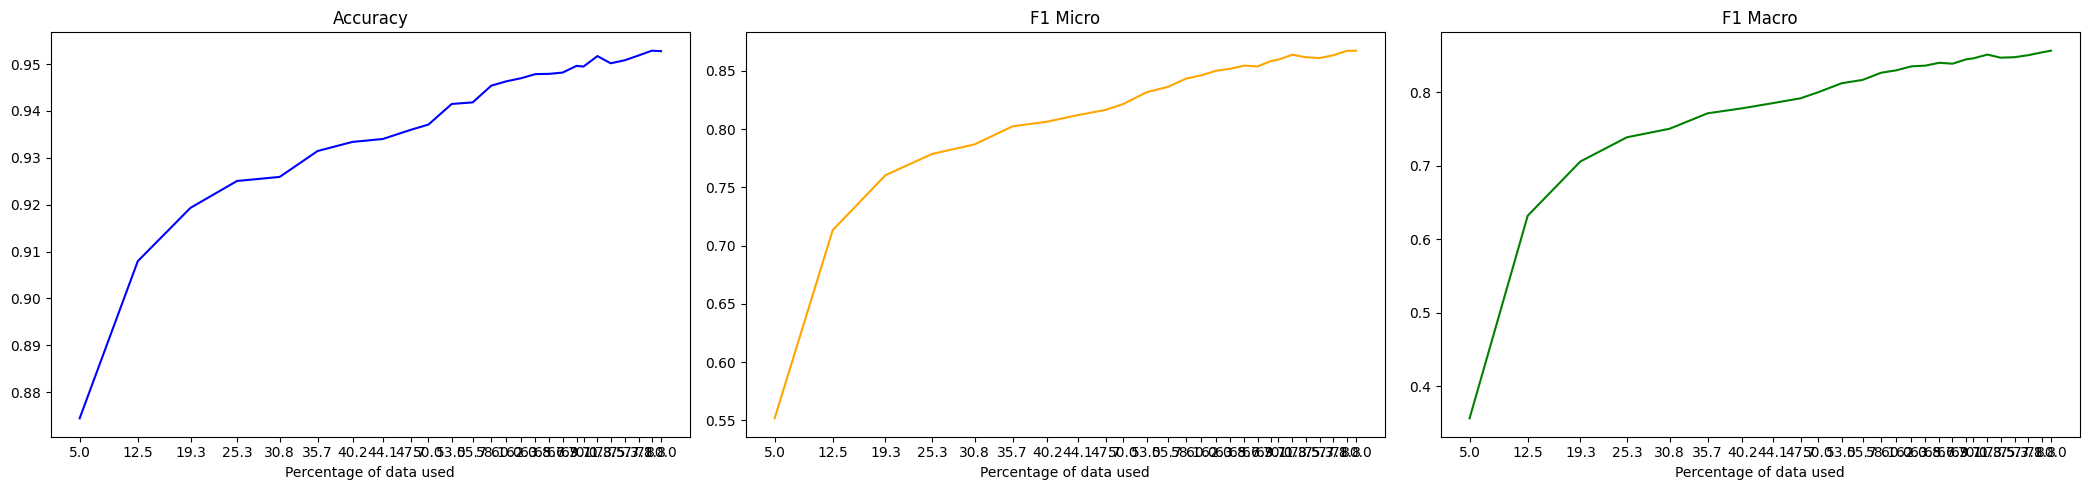

In [23]:
active_learning([50, 67, 42], 0)